In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Conv2DTranspose
from keras.layers import Flatten, Reshape, Lambda, Add, Multiply, Layer, InputLayer
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import plot_model
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from time import clock
from IPython.display import SVG
from random import randint, seed
from keras.utils.vis_utils import model_to_dot, plot_model
from sklearn.model_selection import train_test_split
from keras_utils import ModelSaveCallback, TqdmProgressCallback
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]
    plt.rcParams["figure.figsize"] = (15, 5)
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.imshow(img)

In [3]:
def show_samples():
    seed(clock())
    offset = randint(0,x_train.shape[0]-30)
    plt.rcParams["figure.figsize"] = (20, 8)
    for i in range(30):
        plt.subplot(3,10,i+1)
        plt.imshow(x_train[offset + i])

In [4]:
def VariationalAutoEncoder(img_shape, code_size):
            
    img_input = Input(shape=img_shape)

    encoder = (Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="elu"))(img_input)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3, 3), padding="same"))(encoder)
    encoder = (Flatten())(encoder)
        
    encoder_mean = (Dense(units=64, activation="elu"))(encoder)
    encoder_log_sigma = (Dense(units=64, activation="elu"))(encoder)
    
    encoder_model = Model(inputs=img_input, outputs=[encoder_mean, encoder_log_sigma])
    encoder_model.name = "Encoder_Model"
    
    ###########################################################################################

    decoder = Sequential()
    decoder_input = Input(shape=(code_size,))
                
    decoder = (Dense(units=512, activation="elu"))(decoder_input)
    decoder = (Reshape(target_shape=(2, 2, 128)))(decoder)
    decoder = (Conv2DTranspose(filters=128, kernel_size=(3,3), activation="elu", strides=2, padding="same"))(decoder)   
    decoder = (Conv2DTranspose(filters=64, kernel_size=(3,3), activation="elu", strides=2, padding="same"))(decoder)  
    decoder = (Conv2DTranspose(filters=32, kernel_size=(3,3), activation="elu", strides=2, padding="same"))(decoder)  
    decoder = (Conv2DTranspose(filters=3, kernel_size=(3,3), strides=2, padding="same"))(decoder)
    
    decoder_model = Model(inputs=decoder_input, outputs=decoder)
    decoder_model.name = "Decoder_Model"
    
    return encoder_model, decoder_model

In [5]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

In [6]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [7]:
IMG_SHAPE = x_train[0].shape
CODE_SIZE = 64
encoder, decoder = VariationalAutoEncoder(img_shape = IMG_SHAPE, code_size=CODE_SIZE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 11, 11, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 64)   18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

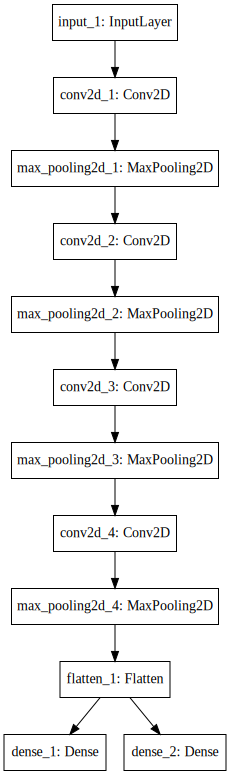

In [8]:
plot_model(encoder, to_file='EncoderSection.png')
encoder.summary()
SVG(model_to_dot(encoder,show_shapes=False).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               33280     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 273,987
Trainable params: 273,987
Non-trainable params: 0
_________________________________________________________________


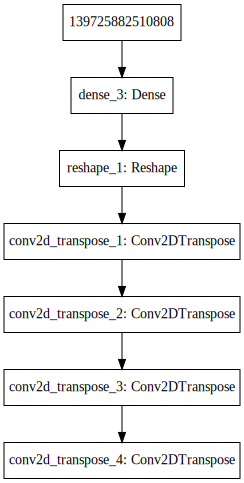

In [9]:
plot_model(decoder, to_file='DecoderSection.png')
decoder.summary()
SVG(model_to_dot(decoder,show_shapes=False).create(prog='dot', format='svg'))

In [10]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [11]:
image_input = Input(shape=IMG_SHAPE, name="Image_Input")

mean_encoding, log_sigma_encoding = encoder(inputs=image_input)

mean_encoding, log_sigma_encoding = KLDivergenceLayer(name="KLD_Layer")([mean_encoding, log_sigma_encoding])
z_sigma = Lambda(lambda t: K.exp(.5*t), name="Sampling_Layer")(log_sigma_encoding)
eps = Input(tensor=K.random_normal(shape=(K.shape(image_input)[0], CODE_SIZE)), name="Random_Noise")
z_eps = Multiply(name="Multiplication_Layer")([z_sigma, eps])
sampled_vector = Add(name="Addition_Layer")([mean_encoding, z_eps])

reconstructed_image = decoder(sampled_vector)

vae_model = Model(inputs=[image_input,eps], outputs=reconstructed_image)
vae_model.compile(optimizer = "adam", loss=nll)

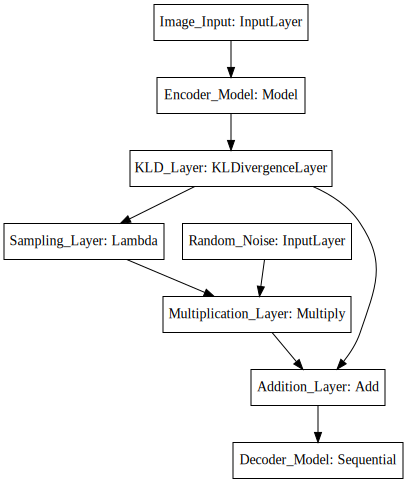

In [12]:
SVG(model_to_dot(vae_model, show_shapes=False).create(prog='dot', format='svg'))

In [ ]:
vae_model.fit(x_train,
        x_train,
        shuffle=True,
        epochs=30,
        batch_size=16,
        validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30


In [ ]:
vae_model.fit(x=x_train, 
                  y=x_train,
                  epochs = 30,
                  validation_data=[x_test, x_test],
                  callbacks = [
                            TensorBoard(log_dir="logs/final/{}".format(clock()), histogram_freq=1),
                            TqdmProgressCallback()
                              ]
             )